# Comprehensive Financial Analysis and Forecasting Plan

## Objectives

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
Great job, Aleksandr! For the next iteration please add your conclusions, recommendations and dashboard
</div>

- Identify trends in revenue and profit over time.
- Predict future revenue and profit using time-series forecasting techniques. 
- Uncover the most profitable categories, segments, regions, and countries.
- Investigate the impact of seasonality and yearly trends on profit margins.


## Packages and functions for the analysis of the data

In [1]:

import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import seaborn as sns

/Users/alexander/Desktop/Final Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alexander/Desktop/Final Project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def columns_names(name_table):
    conn = sqlite3.connect('atliq_db.sqlite3')
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info({name_table})")
    columns = [row[1] for row in cursor.fetchall()]
    conn.close()
    return columns

In [3]:
def duplicated_rows_pd(name_table):
    conn = sqlite3.connect('atliq_db.sqlite3')
    cursor = conn.cursor()
    cursor.execute(f"SELECT * FROM {name_table}")
    df = pd.DataFrame(cursor.fetchall())
    conn.close()
    return df[df.duplicated()]

In [4]:
def duplicated_rows_sql(name_table):
    conn = sqlite3.connect('atliq_db.sqlite3')
    cursor = conn.cursor()
    cursor.execute(f"SELECT * FROM {name_table} GROUP BY {' ,'.join(columns_names(name_table))} HAVING COUNT(*) > 1")
    rows = cursor.fetchall()
    conn.close()
    return rows

In [5]:
def missing_values_pd(name_table):
    conn = sqlite3.connect('atliq_db.sqlite3')
    cursor = conn.cursor()
    cursor.execute(f"SELECT * FROM {name_table}")
    df = pd.DataFrame(cursor.fetchall())
    conn.close()
    return df.isnull().sum()

In [6]:
def missing_values_sql(name_table):
    conn = sqlite3.connect('atliq_db.sqlite3')
    cursor = conn.cursor()
    cursor.execute(f"SELECT COUNT(*) FROM {name_table} WHERE {' OR '.join([f'{column} IS NULL' for column in columns_names(name_table)])}")
    rows = cursor.fetchall()[0][0]
    conn.close()
    return rows

In [7]:
def stats(data):
    for column in data.columns:
        if data[column].dtype == 'float64' or data[column].dtype == 'int64':
            print(f"Column: {column}: \n")
            print(f"Mean: {data[column].mean():.2f}")
            print(f"Median: {data[column].median():.2f}")
            print(f"Mode: {data[column].mode()[0]:.2f}")
            print(f"Standard Deviation: {data[column].std():.2f}")
            print(f"Variance: {data[column].var():.2f}")
            print(f"Minimum: {data[column].min():.2f}")
            print(f"Maximum: {data[column].max():.2f}")
            print('\n')
        

In [8]:
def check_stationarity(data, column, freq= 12):
    #Check Stationarity
    rolling_mean = data[column].rolling(window=freq).mean()
    rolling_std = data[column].rolling(window=freq).std()
    plt.plot(data[column], color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show(block=False)
    adft = adfuller(data[column], autolag='AIC')
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , 
                              "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print(output_df)
    

In [9]:
def autocorrelation(data, column):
    autocorrelation_1 = data[column].autocorr(lag=1)
    autocorrelation_3 = data[column].autocorr(lag=3)
    autocorrelation_6 = data[column].autocorr(lag=6)
    autocorrelation_9 = data[column].autocorr(lag=9)
    autocorrelation_12 = data[column].autocorr(lag=12)
    print(f"1 Month Lag: {autocorrelation_1:.2f}")
    print(f"3 Month Lag: {autocorrelation_3:.2f}")
    print(f"6 Month Lag: {autocorrelation_6:.2f}")
    print(f"9 Month Lag: {autocorrelation_9:.2f}")
    print(f"12 Month Lag: {autocorrelation_12:.2f}")

In [10]:
def decompose(data, column, freq= 12):
    result = seasonal_decompose(data[column], model='additive', period=freq)
    result.plot()
    plt.show()

In [11]:
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

## Data Preparation and EDA

In [12]:
con = sqlite3.connect('atliq_db.sqlite3')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for el in tables:
    print(f"Table: {el[0]}")
    print(f"Columns: {columns_names(el[0])}")
    print(f"Duplicated rows: {duplicated_rows_sql(el[0])}")
    print(f"Missing values: {missing_values_sql(el[0])}")
    print("\n")
con.close()

Table: dim_customer
Columns: ['customer_code', 'customer', 'platform', 'channel', 'market', 'sub_zone', 'region']
Duplicated rows: []
Missing values: 0


Table: dim_product
Columns: ['product_code', 'division', 'segment', 'category', 'product', 'variant']
Duplicated rows: []
Missing values: 0


Table: fact_pre_discount
Columns: ['customer_code', 'fiscal_year', 'pre_invoice_discount_pct']
Duplicated rows: []
Missing values: 0


Table: fact_manufacturing_cost
Columns: ['product_code', 'cost_year', 'manufacturing_cost']
Duplicated rows: []
Missing values: 0


Table: fact_gross_price
Columns: ['product_code', 'fiscal_year', 'gross_price']
Duplicated rows: []
Missing values: 0


Table: fact_sales_monthly
Columns: ['date', 'product_code', 'customer_code', 'sold_quantity', 'fiscal_year']
Duplicated rows: []
Missing values: 1




In [13]:
query = "SELECT * FROM fact_sales_monthly WHERE date is NULL OR product_code is NULL OR customer_code is NULL OR sold_quantity is NULL OR fiscal_year is NULL"
con = sqlite3.connect('atliq_db.sqlite3')
cursor = con.cursor()
cursor.execute(query)
print(cursor.fetchall())
cursor.close()

[('2019-06-01', 'A0', None, None, None)]


There aren't any duplicated rows or missing values in our tables, except one row in fact_sales_monthly.
But we should check if there are missing values after joining tables.

In [14]:
query_revenue_profit_margin_by_date = """
SELECT fact_sales_monthly.date as date, 
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price) as revenue,
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price * (1 - fact_pre_discount.pre_invoice_discount_pct)) as net_revenue,
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price * (1 - fact_pre_discount.pre_invoice_discount_pct) - fact_sales_monthly.sold_quantity * fact_manufacturing_cost.manufacturing_cost) as profit,
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price  - fact_sales_monthly.sold_quantity * fact_manufacturing_cost.manufacturing_cost) as margin
FROM fact_sales_monthly
JOIN fact_gross_price on fact_sales_monthly.product_code = fact_gross_price.product_code and fact_sales_monthly.fiscal_year = fact_gross_price.fiscal_year
JOIN fact_pre_discount on fact_sales_monthly.customer_code = fact_pre_discount.customer_code and fact_sales_monthly.fiscal_year = fact_pre_discount.fiscal_year
JOIN fact_manufacturing_cost on fact_sales_monthly.product_code = fact_manufacturing_cost.product_code and fact_sales_monthly.fiscal_year = fact_manufacturing_cost.cost_year
WHERE fact_sales_monthly.product_code != 'A0'
group by fact_sales_monthly.date
"""


In [15]:
re_pr_mar = pd.read_sql_query(query_revenue_profit_margin_by_date, con)

In [16]:
re_pr_mar.head()

,date,revenue,net_revenue,profit,margin
0,2017-09-01,203560.7803,153549.701158,93062.022658,143073.1018
1,2017-10-01,264533.7946,204034.466872,125544.383072,186043.7108
2,2017-11-01,375191.4062,286992.281537,175719.521937,263918.6466
3,2017-12-01,385598.6583,290756.322045,176160.413445,271002.7497
4,2018-01-01,208699.9808,158192.241717,96281.863717,146789.6028


In [17]:
re_pr_mar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         52 non-null     object 
 1   revenue      52 non-null     float64
 2   net_revenue  52 non-null     float64
 3   profit       52 non-null     float64
 4   margin       52 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.2+ KB


In [18]:
stats(re_pr_mar)

Column: revenue: 

Mean: 1664536.71
Median: 838940.36
Mode: 153656.79
Standard Deviation: 2566058.63
Variance: 6584656873973.27
Minimum: 153656.79
Maximum: 12358833.62


Column: net_revenue: 

Mean: 1275238.07
Median: 647014.46
Mode: 117623.65
Standard Deviation: 1961193.59
Variance: 3846280304601.22
Minimum: 117623.65
Maximum: 9347548.67


Column: profit: 

Mean: 781206.57
Median: 397853.08
Mode: 71844.04
Standard Deviation: 1202415.04
Variance: 1445801918616.04
Minimum: 71844.04
Maximum: 5693377.08


Column: margin: 

Mean: 1170505.21
Median: 589778.98
Mode: 107877.17
Standard Deviation: 1807218.78
Variance: 3266039723820.70
Minimum: 107877.17
Maximum: 8704662.03




In [19]:
fig_revenue = px.line(re_pr_mar, x='date', y='revenue', title='Revenue by date')
fig_revenue.update_layout(
    xaxis_title='Date',
    yaxis_title='Revenue'
)
fig_revenue.show()

In [20]:
fig_net_revenue = px.line(re_pr_mar, x='date', y='net_revenue', title='Net Revenue by date')
fig_net_revenue.update_layout(
    yaxis_title='Net Revenue', 
    xaxis_title='Date'
)
fig_net_revenue.show()

In [21]:
fig_profit = px.line(re_pr_mar, x='date', y='profit', title='Profit by date')
fig_profit.update_layout(
    yaxis_title='Profit', 
    xaxis_title='Date'
)
fig_profit.show()

In [22]:
fig_margin = px.line(re_pr_mar, x='date', y='margin', title='Margin by date')
fig_margin.update_layout(
    yaxis_title='Margin', 
    xaxis_title='Date'
)
fig_margin.show()

In [23]:
fig_overall = px.line(re_pr_mar, x='date', y=['revenue', 'net_revenue', 'profit', 'margin'], title='Overall by date')
fig_overall.update_layout(
    yaxis_title='Value', 
    xaxis_title='Date'
)
fig_overall.show()

In [65]:
re_pr_mar.to_csv('revenue_profit_margin.csv', index=True)

As we can see all our metrics is growing overtime. But we should continue observations due to abnormal last year.

In [56]:
query_region = """
select 
dim_customer.region,
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price) as revenue
from fact_sales_monthly
join dim_customer on fact_sales_monthly.customer_code = dim_customer.customer_code
join fact_gross_price on fact_sales_monthly.product_code = fact_gross_price.product_code and fact_sales_monthly.fiscal_year = fact_gross_price.fiscal_year
group by dim_customer.region
""" 

In [57]:
con = sqlite3.connect('atliq_db.sqlite3')
df_region = pd.read_sql_query(query_region, con)
con.close()

In [60]:
fig_region = px.bar(df_region, x='region', y='revenue', title='Revenue by region')
fig_region.show()

In [24]:
query_segment = """
SELECT
dim_product.category,
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price) as revenue,
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price * (1 - fact_pre_discount.pre_invoice_discount_pct)) as net_revenue,
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price * (1 - fact_pre_discount.pre_invoice_discount_pct) - fact_sales_monthly.sold_quantity * fact_manufacturing_cost.manufacturing_cost) as profit,
sum(fact_sales_monthly.sold_quantity * fact_gross_price.gross_price  - fact_sales_monthly.sold_quantity * fact_manufacturing_cost.manufacturing_cost) as margin

FROM fact_sales_monthly
JOIN fact_gross_price on fact_sales_monthly.product_code = fact_gross_price.product_code and fact_sales_monthly.fiscal_year = fact_gross_price.fiscal_year
JOIN fact_pre_discount on fact_sales_monthly.customer_code = fact_pre_discount.customer_code and fact_sales_monthly.fiscal_year = fact_pre_discount.fiscal_year
JOIN fact_manufacturing_cost on fact_sales_monthly.product_code = fact_manufacturing_cost.product_code and fact_sales_monthly.fiscal_year = fact_manufacturing_cost.cost_year
JOIN dim_product on fact_sales_monthly.product_code = dim_product.product_code
WHERE fact_sales_monthly.product_code != 'A0'
group by dim_product.category;
"""

In [25]:
con = sqlite3.connect('atliq_db.sqlite3')
df_category = pd.read_sql_query(query_segment, con)
con.close()

In [26]:
fig_category_revenue = px.bar(df_category, x='category', y='revenue', title='Revenue by category')
fig_category_revenue.update_layout(
    yaxis_title='Revenue', 
    xaxis_title='Category'
)
fig_category_revenue.show()

In [27]:
fig_category_net_revenue = px.bar(df_category, x='category', y='net_revenue', title='Net revenue by category')
fig_category_net_revenue.update_layout(
    yaxis_title='Net Revenue', 
    xaxis_title='Category'
)
fig_category_net_revenue.show()

In [28]:
fig_category_profit = px.bar(df_category, x='category', y='profit', title='Profit by category')
fig_category_profit.update_layout(
    yaxis_title='Profit', 
    xaxis_title='Category'
)
fig_category_profit.show()

In [29]:
fig_category_margin = px.bar(df_category, x='category', y='margin', title='Margin by category')
fig_category_margin.update_layout(
    yaxis_title='Margin', 
    xaxis_title='Category'
)
fig_category_margin.show()

We should get more data on products.

## Trends for profit and margin

In [30]:
re_pr_mar['date'] = pd.to_datetime(re_pr_mar['date'])
re_pr_mar.set_index('date', inplace=True)


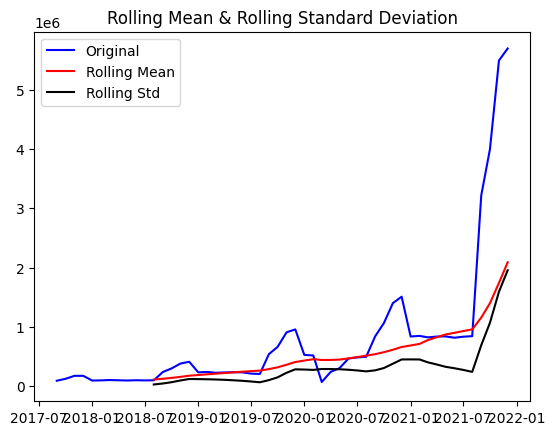

      Values                       Metric
0   2.375876              Test Statistics
1   0.998999                      p-value
2  10.000000             No. of lags used
3  41.000000  Number of observations used
4  -3.600983          critical value (1%)
5  -2.935135          critical value (5%)
6  -2.605963         critical value (10%)


In [31]:
check_stationarity(re_pr_mar, 'profit', 12)

In [32]:
autocorrelation(re_pr_mar, 'profit')

1 Month Lag: 0.94
3 Month Lag: 0.67
6 Month Lag: 0.40
9 Month Lag: 0.53
12 Month Lag: 0.91


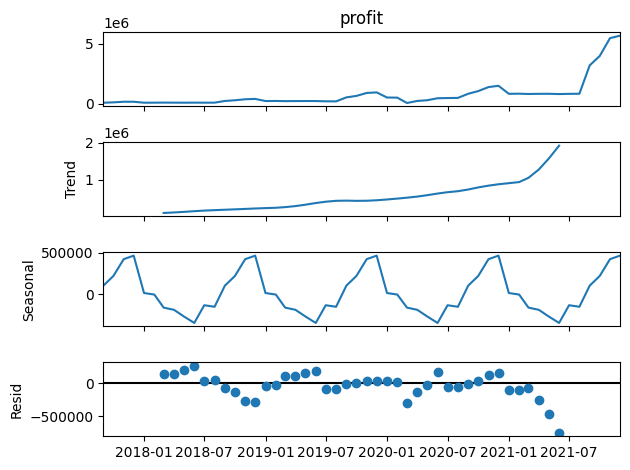

In [33]:
decompose(re_pr_mar, 'profit', 12)

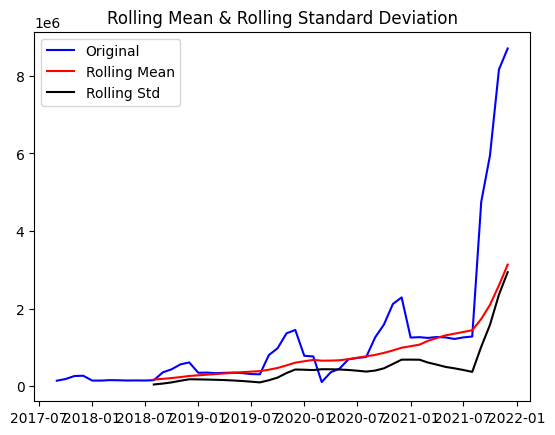

      Values                       Metric
0   2.412559              Test Statistics
1   0.999016                      p-value
2  10.000000             No. of lags used
3  41.000000  Number of observations used
4  -3.600983          critical value (1%)
5  -2.935135          critical value (5%)
6  -2.605963         critical value (10%)


In [34]:
check_stationarity(re_pr_mar, 'margin', 12)

In [35]:
autocorrelation(re_pr_mar, 'margin')

1 Month Lag: 0.95
3 Month Lag: 0.67
6 Month Lag: 0.40
9 Month Lag: 0.53
12 Month Lag: 0.92


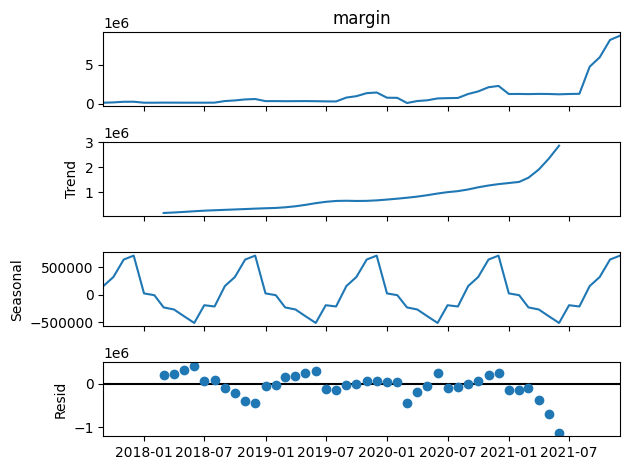

In [36]:
decompose(re_pr_mar, 'margin', 12)

As we can see we have very strong seasonality in our data. We will use SARIMA model to forecast our data.

In [37]:
corr = re_pr_mar.corr()
corr.style.background_gradient(cmap='coolwarm')


,revenue,net_revenue,profit,margin
revenue,1.000000,0.999952,0.999870,0.999999
net_revenue,0.999952,1.000000,0.999979,0.999952
profit,0.999870,0.999979,1.000000,0.999872
margin,0.999999,0.999952,0.999872,1.000000


Our metrics is correlated, so we are going to concentrate on revenue trend. Additional factors in other metrics is not so influent.

## Predictive models

### ARIMA, SARIMA, SARIMAX

In [38]:
auto_arima(re_pr_mar['revenue'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   52
Model:             SARIMAX(0, 1, 3)x(0, 1, [], 12)   Log Likelihood                -579.567
Date:                             Sun, 05 May 2024   AIC                           1167.135
Time:                                     15:36:51   BIC                           1173.789
Sample:                                 09-01-2017   HQIC                          1169.522
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2776      0.444      0.626      0.532      -0.592       1.147
ma.L2          0.9150      0.350      2.614      0.009       0.229       1.601
ma.L3          0.3596      0.518      0.694      0.488      -0.656       1.375
sigma2      6.796e+11   7.82e-13   8.69e+23      0.000     6.8e+11     6.8e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               176.18
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              58.13   Skew:                             2.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+40. Standard errors may be unstable.
"""

In [39]:
train_data = re_pr_mar.iloc[:len(re_pr_mar)-12]
test_data = re_pr_mar.iloc[len(re_pr_mar)-12:]
arima_model = SARIMAX(train_data['revenue'], order=(0,1,3), seasonal_order=(0,1,[],12))
arima_result = arima_model.fit()
arima_result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26779D+00    |proj g|=  8.43530D-02

At iterate    5    f=  9.26592D+00    |proj g|=  1.29412D-02

At iterate   10    f=  9.26576D+00    |proj g|=  1.61272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   2.783D-06   9.266D+00
  F =   9.2657067357454146     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/alexander/Desktop/Final Project/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/alexander/Desktop/Final Project/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             revenue   No. Observations:                   40
Model:             SARIMAX(0, 1, 3)x(0, 1, [], 12)   Log Likelihood                -370.628
Date:                             Sun, 05 May 2024   AIC                            749.257
Time:                                     15:36:51   BIC                            754.440
Sample:                                 09-01-2017   HQIC                           750.798
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0678      0.323      0.210      0.834      -0.566       0.701
ma.L2          0.6533      0.291      2.246      0.025       0.083       1.223
ma.L3         -0.3818      0.328     -1.165      0.244      -1.024       0.260
sigma2      7.008e+10   2.12e-12   3.31e+22      0.000    7.01e+10    7.01e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.12
Prob(Q):                              0.90   Prob(JB):                         0.03
Heteroskedasticity (H):               7.59   Skew:                            -0.81
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [40]:
arima_pred = arima_result.predict(start=len(train_data), end=len(re_pr_mar)-1, typ='levels').rename('ARIMA Predictions')
arima_pred

/Users/alexander/Desktop/Final Project/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



2021-01-01    2.462101e+06
2021-02-01    2.420626e+06
2021-03-01    1.438632e+06
2021-04-01    1.799073e+06
2021-05-01    1.931037e+06
2021-06-01    2.273064e+06
2021-07-01    2.324166e+06
2021-08-01    2.357700e+06
2021-09-01    3.081276e+06
2021-10-01    3.548081e+06
2021-11-01    4.306061e+06
2021-12-01    4.546278e+06
Freq: MS, Name: ARIMA Predictions, dtype: float64

<Axes: xlabel='date'>

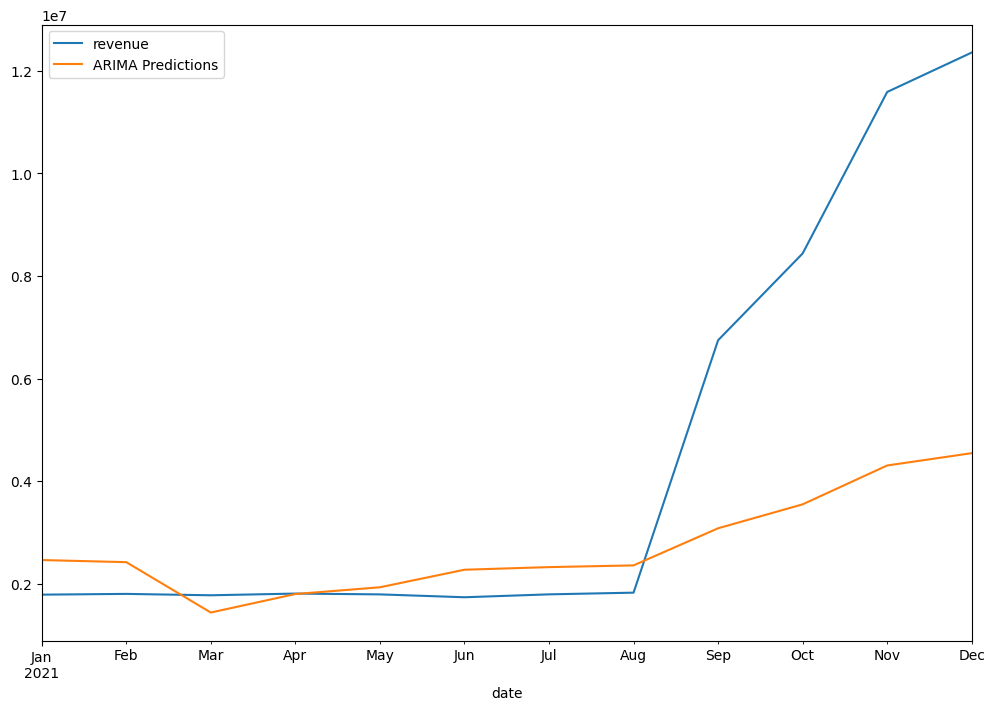

In [41]:
test_data['revenue'].plot(legend=True, figsize=(12,8))
arima_pred.plot(legend=True)

### Prophet

In [42]:
df_prophet = re_pr_mar.copy()
df_prophet.reset_index(inplace=True)
df_prophet = df_prophet.rename(columns={'date':'ds', 'revenue':'y'})
df_prophet = df_prophet[['ds', 'y']]
train_data_prophet = df_prophet.iloc[:len(df_prophet)-12]
test_data_prophet = df_prophet.iloc[len(df_prophet)-12:]

In [43]:
m = Prophet()
m.fit(train_data_prophet)
future = m.make_future_dataframe(periods=12, freq='ME')
prophet_pred = m.predict(future)
prophet_pred.tail()


15:36:52 - cmdstanpy - INFO - Chain [1] start processing
15:36:52 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
47,2021-07-31,1.995903e+06,1.478085e+06,2.172948e+06,1.995902e+06,1.995904e+06,-149494.547595,-149494.547595,-149494.547595,-149494.547595,-149494.547595,-149494.547595,0.0,0.0,0.0,1.846408e+06
48,2021-08-31,2.045569e+06,2.157739e+06,2.911559e+06,2.045568e+06,2.045571e+06,500080.399347,500080.399347,500080.399347,500080.399347,500080.399347,500080.399347,0.0,0.0,0.0,2.545650e+06
49,2021-09-30,2.093634e+06,2.392009e+06,3.105409e+06,2.093633e+06,2.093636e+06,644602.764739,644602.764739,644602.764739,644602.764739,644602.764739,644602.764739,0.0,0.0,0.0,2.738237e+06
50,2021-10-31,2.143301e+06,2.655595e+06,3.395948e+06,2.143299e+06,2.143303e+06,856011.503083,856011.503083,856011.503083,856011.503083,856011.503083,856011.503083,0.0,0.0,0.0,2.999313e+06
51,2021-11-30,2.191366e+06,2.533080e+06,3.281160e+06,2.191364e+06,2.191368e+06,730075.239261,730075.239261,730075.239261,730075.239261,730075.239261,730075.239261,0.0,0.0,0.0,2.921441e+06


In [44]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "ME"
prophet_pred


,Pred
Date,
2020-12-31,1.856144e+06
2021-01-31,1.352547e+06
2021-02-28,2.196196e+06
2021-03-31,1.688320e+06
2021-04-30,1.561252e+06
2021-05-31,1.400584e+06
2021-06-30,1.579269e+06
2021-07-31,1.846408e+06
2021-08-31,2.545650e+06


/var/folders/pk/z8kgnyd97dd7xxlxf5kby7g00000gn/T/ipykernel_70859/2625551491.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='date', ylabel='revenue'>

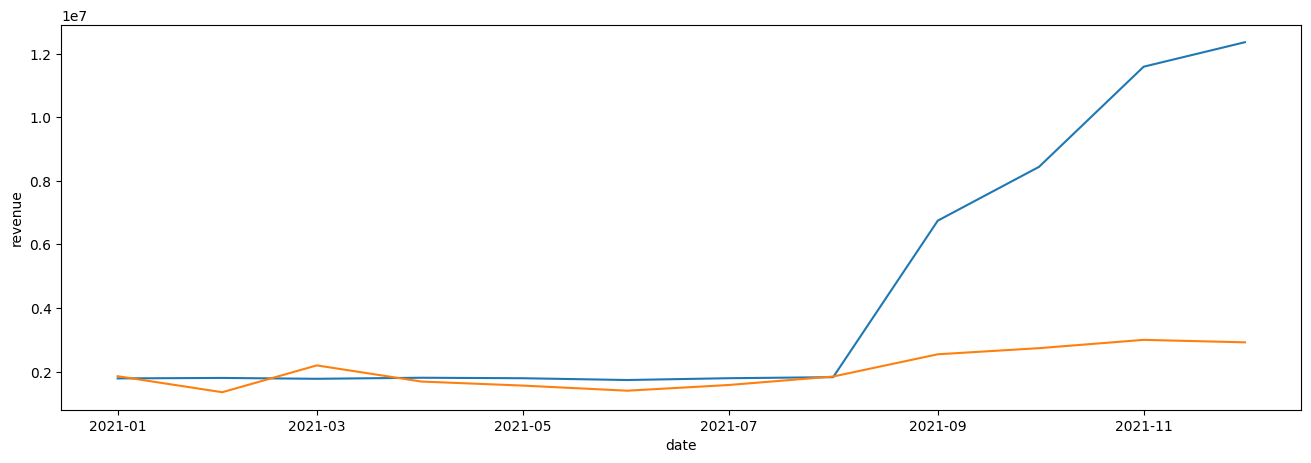

In [62]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["revenue"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"])

As we can see SARIMA and Prophet models cant predict with this data, for this model we should continue our observation due to abnormal 2021 year.

In [76]:
test_data["ARIMA_Predictions"] = arima_pred.values

final_df_ts = pd.concat([train_data['revenue'], test_data[['revenue', 'ARIMA_Predictions', 'Prophet_Predictions']]], axis=0) 
final_df_ts.to_csv('final_df_ts.csv', index=True)

/var/folders/pk/z8kgnyd97dd7xxlxf5kby7g00000gn/T/ipykernel_70859/2891243133.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### LSTM

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2024-05-05 15:36:58.380564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
tf.random.set_seed(7)

In [48]:
dataset = re_pr_mar['revenue'].values
dataset = dataset.astype('float32')

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))


In [50]:
test_size = 12
train_size = len(dataset) - test_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [51]:
trainX, trainY = create_dataset(train, 1)
testX, testY = create_dataset(test, 1)

In [52]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [53]:

model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


/Users/alexander/Desktop/Final Project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



38/38 - 1s - 39ms/step - loss: 0.0045
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 0.0033
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 0.0032
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 0.0031
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 0.0031
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.0030
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.0030
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.0029
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.0028
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.0028
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.0027
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.0027
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.0026
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.0026
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.0025
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.0025
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.0024
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.0024
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.0023
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.0023
Epoch 21/100
38/38 -

In [54]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train Score: 338268.72 RMSE
Test Score: 1717663.68 RMSE


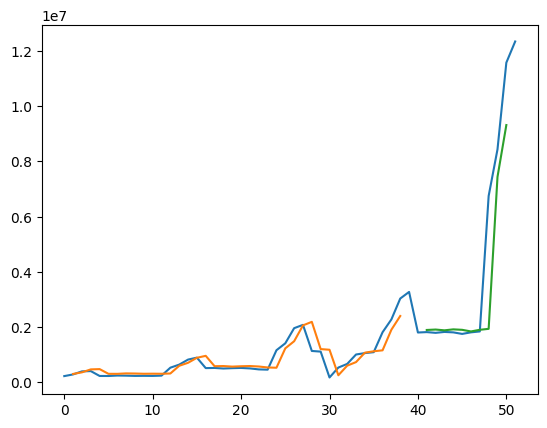

In [55]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(1*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [92]:
d = {
    'revenue': scaler.inverse_transform(dataset)[:,0],
    'train': trainPredictPlot[:,0],
    'test': testPredictPlot[:,0]
    
}
lstm_df = pd.DataFrame(data=d, index = final_df_ts.index)
lstm_df.to_csv('lstm_df.csv', index=True)

Even though LSTM is much more sophisticated method but it can predict better than SARIMAX and Prophet.

<b>As we see in our analysis we have strong seasonality and grow over the years, even without abnormal 2021 year. But we should definitely improve our lowest months(Jan-Jul).Also we have potential in growth in region Latin America. Overall we should continue observation and get more data on products.</b>


Dashboard: https://public.tableau.com/views/Book1_17149192499630/Dashboard2?:language=en-GB&:sid=&:display_count=n&:origin=viz_share_link